# Fully-Connected Neural Nets

In this notebook we will implement fully-connected networks using a modular approach. For each layer we will implement a `forward` and a `backward` function. The `forward` function will receive inputs, weights, and other parameters and will return both an output and a `cache` object storing data needed for the backward pass, like this:

```python
def layer_forward(x, w):
  """ Receive inputs x and weights w """
  # Do some computations ...
  z = # ... some intermediate value
  # Do some more computations ...
  out = # the output
   
  cache = (x, w, z, out) # Values we need to compute gradients
  
  return out, cache
```

The backward pass will receive upstream derivatives and the `cache` object, and will return gradients with respect to the inputs and weights, like this:

```python
def layer_backward(dout, cache):
  """
  Receive derivative of loss with respect to outputs and cache,
  and compute derivative with respect to inputs.
  """
  # Unpack cache values
  x, w, z, out = cache
  
  # Use values in cache to compute derivatives
  dx = # Derivative of loss with respect to x
  dw = # Derivative of loss with respect to w
  
  return dx, dw
```

After implementing a bunch of layers this way, we will be able to easily combine them to build classifiers with different architectures.

In addition to implementing fully-connected networks of arbitrary depth, we will also explore different update rules for optimization.

In [1]:
# As usual, a bit of setup

import time
import numpy as np
import matplotlib.pyplot as plt
from deeplearning.classifiers.fc_net import *
from deeplearning.data_utils import get_CIFAR10_data
from deeplearning.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from deeplearning.solver import Solver
import random 
seed = 7
random.seed(seed)
np.random.seed(seed)

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [2]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in data.items():
    print('%s: ' % k, v.shape)

deeplearning/datasets/cifar-10-batches-py/data_batch_1
deeplearning/datasets/cifar-10-batches-py/data_batch_2
deeplearning/datasets/cifar-10-batches-py/data_batch_3
deeplearning/datasets/cifar-10-batches-py/data_batch_4
deeplearning/datasets/cifar-10-batches-py/data_batch_5
deeplearning/datasets/cifar-10-batches-py/test_batch
X_train:  (49000, 3, 32, 32)
y_train:  (49000,)
X_val:  (1000, 3, 32, 32)
y_val:  (1000,)
X_test:  (1000, 3, 32, 32)
y_test:  (1000,)


# Part 1) Affine Layers
# Affine layer: forward
Open the file `deeplearning/layers.py` and implement the `affine_forward` function.

Once you are done you can test your implementaion by running the following:

In [3]:
# Test the affine_forward function

num_inputs = 2
input_shape = (4, 5, 6)
output_dim = 3

input_size = num_inputs * np.prod(input_shape)
weight_size = output_dim * np.prod(input_shape)

x = np.linspace(-0.1, 0.5, num=input_size).reshape(num_inputs, *input_shape)
w = np.linspace(-0.2, 0.3, num=weight_size).reshape(np.prod(input_shape), output_dim)
b = np.linspace(-0.3, 0.1, num=output_dim)

out, _ = affine_forward(x, w, b)
correct_out = np.array([[ 1.49834967,  1.70660132,  1.91485297],
                        [ 3.25553199,  3.5141327,   3.77273342]])

# Compare your output with ours. The error should be around 1e-9.
print('Testing affine_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing affine_forward function:
difference:  9.769849468192957e-10


# Affine layer: backward
Now implement the `affine_backward` function and test your implementation using numeric gradient checking.

In [5]:
# Test the affine_backward function

x = np.random.randn(10, 2, 3)
w = np.random.randn(6, 5)
b = np.random.randn(5)
dout = np.random.randn(10, 5)

dx_num = eval_numerical_gradient_array(lambda x: affine_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_forward(x, w, b)[0], b, dout)

_, cache = affine_forward(x, w, b)
dx, dw, db = affine_backward(dout, cache)
# The error should be around 1e-10
print('Testing affine_backward function:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_backward function:
dx error:  9.363052411750057e-10
dw error:  3.5931047409534836e-11
db error:  4.0308470407483046e-12


# Part 2) ReLU Layers
# ReLU layer: forward
Implement the forward pass for the ReLU activation function in the `relu_forward` function and test your implementation using the following:

In [6]:
# Test the relu_forward function

x = np.linspace(-0.5, 0.5, num=12).reshape(3, 4)

out, _ = relu_forward(x)
correct_out = np.array([[ 0.,          0.,          0.,          0.,        ],
                        [ 0.,          0.,          0.04545455,  0.13636364,],
                        [ 0.22727273,  0.31818182,  0.40909091,  0.5,       ]])

# Compare your output with ours. The error should be around 1e-8
print('Testing relu_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing relu_forward function:
difference:  4.999999798022158e-08


# ReLU layer: backward
Now implement the backward pass for the ReLU activation function in the `relu_backward` function and test your implementation using numeric gradient checking. Note that the ReLU activation is not differentiable at 0, but typically we don't worry about this and simply assign either 0 or 1 as the derivative by convention.

In [7]:
x = np.random.randn(10, 10)
dout = np.random.randn(*x.shape)

dx_num = eval_numerical_gradient_array(lambda x: relu_forward(x)[0], x, dout)

_, cache = relu_forward(x)
dx = relu_backward(dout, cache)

# The error should be around 1e-12
print('Testing relu_backward function:')
print('dx error: ', rel_error(dx_num, dx))

Testing relu_backward function:
dx error:  3.275611372854648e-12


# "Sandwich" layers
There are some common patterns of layers that are frequently used in neural nets. For example, affine layers are frequently followed by a ReLU nonlinearity. To make these common patterns easy, we define several convenience layers in the file `deeplearning/layer_utils.py`.

For now take a look at the `affine_relu_forward` and `affine_relu_backward` functions, and run the following to numerically gradient check the backward pass:

In [8]:
from deeplearning.layer_utils import affine_relu_forward, affine_relu_backward

x = np.random.randn(2, 3, 4)
w = np.random.randn(12, 10)
b = np.random.randn(10)
dout = np.random.randn(2, 10)

out, cache = affine_relu_forward(x, w, b)
dx, dw, db = affine_relu_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: affine_relu_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_relu_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_relu_forward(x, w, b)[0], b, dout)

print('Testing affine_relu_forward:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_relu_forward:
dx error:  1.1961709192327207e-10
dw error:  1.4786575651608947e-10
db error:  8.885199152015734e-11


# Loss layers: Softmax and SVM
Here we provide two loss functions that we will use to train our deep neural networks. You should understand how they work by looking at the implementations in `deeplearning/layers.py`.

You can make sure that the implementations are correct by running the following:

In [9]:
num_classes, num_inputs = 10, 50
x = 0.001 * np.random.randn(num_inputs, num_classes)
y = np.random.randint(num_classes, size=num_inputs)

dx_num = eval_numerical_gradient(lambda x: svm_loss(x, y)[0], x, verbose=False)
loss, dx = svm_loss(x, y)

# Test svm_loss function. Loss should be around 9 and dx error should be 1e-9
print('Testing svm_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))

dx_num = eval_numerical_gradient(lambda x: softmax_loss(x, y)[0], x, verbose=False)
loss, dx = softmax_loss(x, y)

# Test softmax_loss function. Loss should be 2.3 and dx error should be 1e-8
print('\nTesting softmax_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))

Testing svm_loss:
loss:  9.001364019018416
dx error:  8.182894472887002e-10

Testing softmax_loss:
loss:  2.302721899957667
dx error:  6.7476605420995355e-09


# Part 3) Two-layer network

Open the file `deeplearning/classifiers/fc_net.py` and complete the implementation of the `TwoLayerNet` class. This class will serve as a model for the other networks you will implement in this assignment, so read through it to make sure you understand the API. Run the cell below to test your implementation.

In [10]:
N, D, H, C = 3, 5, 50, 7
X = np.random.randn(N, D)
y = np.random.randint(C, size=N)

std = 1e-2
model = TwoLayerNet(input_dim=D, hidden_dim=H, num_classes=C, weight_scale=std)

print ('Testing initialization ... ')
W1_std = abs(model.params['W1'].std() - std)
b1 = model.params['b1']
W2_std = abs(model.params['W2'].std() - std)
b2 = model.params['b2']
assert W1_std < std / 10, 'First layer weights do not seem right'
assert np.all(b1 == 0), 'First layer biases do not seem right'
assert W2_std < std / 10, 'Second layer weights do not seem right'
assert np.all(b2 == 0), 'Second layer biases do not seem right'

print ('Testing test-time forward pass ... ')
model.params['W1'] = np.linspace(-0.7, 0.3, num=D*H).reshape(D, H)
model.params['b1'] = np.linspace(-0.1, 0.9, num=H)
model.params['W2'] = np.linspace(-0.3, 0.4, num=H*C).reshape(H, C)
model.params['b2'] = np.linspace(-0.9, 0.1, num=C)
X = np.linspace(-5.5, 4.5, num=N*D).reshape(D, N).T
scores = model.loss(X)
correct_scores = np.asarray(
  [[11.53165108,  12.2917344,   13.05181771,  13.81190102,  14.57198434, 15.33206765,  16.09215096],
   [12.05769098,  12.74614105,  13.43459113,  14.1230412,   14.81149128, 15.49994135,  16.18839143],
   [12.58373087,  13.20054771,  13.81736455,  14.43418138,  15.05099822, 15.66781506,  16.2846319 ]])
scores_diff = np.abs(scores - correct_scores).sum()
assert scores_diff < 1e-6, 'Problem with test-time forward pass'

print ('Testing training loss (no regularization)')
y = np.asarray([0, 5, 1])
loss, grads = model.loss(X, y)
correct_loss = 3.4702243556
assert abs(loss - correct_loss) < 1e-10, 'Problem with training-time loss'

model.reg = 1.0
loss, grads = model.loss(X, y)
correct_loss = 26.5948426952
assert abs(loss - correct_loss) < 1e-10, 'Problem with regularization loss'

for reg in [0.0, 0.7]:
    print ('Running numeric gradient check with reg = ', reg)
    model.reg = reg
    loss, grads = model.loss(X, y)

    for name in sorted(grads):
        f = lambda _: model.loss(X, y)[0]
        grad_num = eval_numerical_gradient(f, model.params[name], verbose=False)
        print ('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Testing initialization ... 
Testing test-time forward pass ... 
Testing training loss (no regularization)
Running numeric gradient check with reg =  0.0
W1 relative error: 1.52e-08
W2 relative error: 3.21e-10
b1 relative error: 8.37e-09
b2 relative error: 4.33e-10
Running numeric gradient check with reg =  0.7
W1 relative error: 3.12e-07
W2 relative error: 2.85e-08
b1 relative error: 1.56e-08
b2 relative error: 7.76e-10


# Solver
Following a modular design, for this assignment we have split the logic for training models into a separate class from the models themselves.

Open the file `deeplearning/solver.py` and read through it to familiarize yourself with the API. After doing so, use a `Solver` instance to train a `TwoLayerNet` that achieves at least `50%` accuracy on the validation set.

In [11]:
model = TwoLayerNet()
solver = None

##############################################################################
# Use a Solver instance to train a TwoLayerNet that achieves at least  #
# 50% accuracy on the validation set.                                        #
##############################################################################
optim_config = {}
optim_config['learning_rate'] = 0.001
solver = Solver(model, data, optim_config=optim_config, lr_decay=0.9, num_epochs=10)
solver.train()
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

(Iteration 1 / 4900) loss: 2.298283
(Epoch 0 / 10) train acc: 0.127000; val_acc: 0.158000
(Iteration 11 / 4900) loss: 2.236806
(Iteration 21 / 4900) loss: 2.102793
(Iteration 31 / 4900) loss: 1.961671
(Iteration 41 / 4900) loss: 1.973704
(Iteration 51 / 4900) loss: 1.993004
(Iteration 61 / 4900) loss: 1.766126
(Iteration 71 / 4900) loss: 1.841984
(Iteration 81 / 4900) loss: 1.768555
(Iteration 91 / 4900) loss: 1.754210
(Iteration 101 / 4900) loss: 1.896239
(Iteration 111 / 4900) loss: 1.927889
(Iteration 121 / 4900) loss: 1.778648
(Iteration 131 / 4900) loss: 1.813250
(Iteration 141 / 4900) loss: 1.796024
(Iteration 151 / 4900) loss: 1.832001
(Iteration 161 / 4900) loss: 1.662860
(Iteration 171 / 4900) loss: 1.713387
(Iteration 181 / 4900) loss: 1.669743
(Iteration 191 / 4900) loss: 1.626855
(Iteration 201 / 4900) loss: 1.687514
(Iteration 211 / 4900) loss: 1.693027
(Iteration 221 / 4900) loss: 1.763332
(Iteration 231 / 4900) loss: 1.575943
(Iteration 241 / 4900) loss: 1.580068
(Iterat

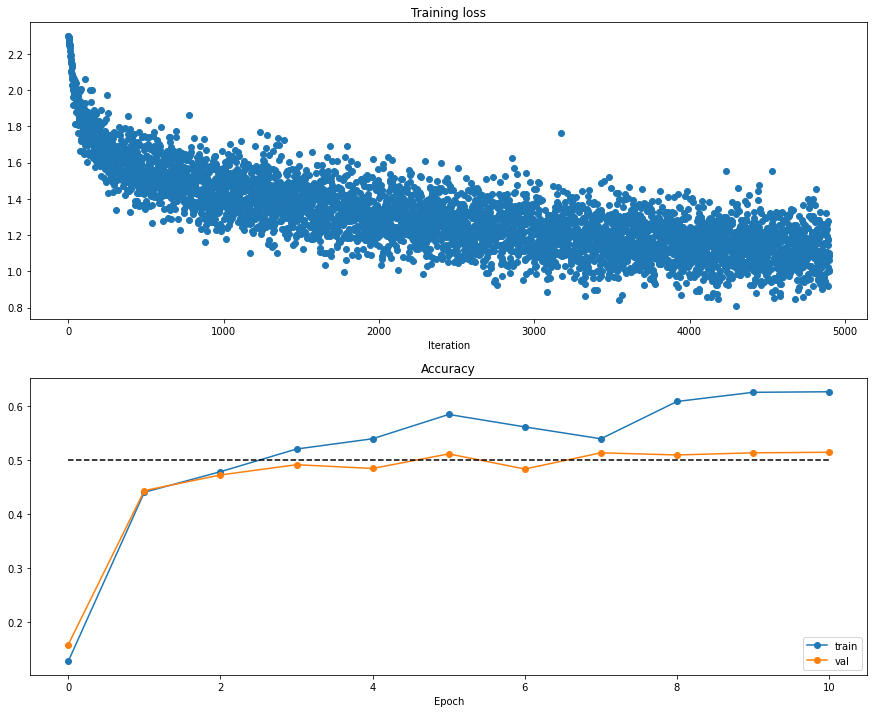

In [12]:
# Run this cell to visualize training loss and train / val accuracy, and save the log file of the
# experiment for submission.

plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(solver.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solver.train_acc_history, '-o', label='train')
plt.plot(solver.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

solver.record_histories_as_npz('submission_logs/train_2layer_fc.npz')

# Part 4) Multilayer network
Next you will implement a fully-connected network with an arbitrary number of hidden layers.

Read through the `FullyConnectedNet` class in the file `deeplearning/classifiers/fc_net.py`.

Implement the initialization, the forward pass, and the backward pass.

## Initial loss and gradient check

As a sanity check, run the following to check the initial loss and to gradient check the network both with and without regularization. Do the initial losses seem reasonable?

For gradient checking, you should expect to see errors around 1e-6 or less.

In [13]:
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for reg in [0, 3.14]:
    print ('Running check with reg = ', reg)
    model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                              reg=reg, weight_scale=5e-2, dtype=np.float64)

    loss, grads = model.loss(X, y)
    print ('Initial loss: ', loss)

    for name in sorted(grads):
        f = lambda _: model.loss(X, y)[0]
        grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
        print ('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Running check with reg =  0
Initial loss:  2.292536482136743
W1 relative error: 1.49e-07
W2 relative error: 1.00e-06
W3 relative error: 9.57e-08
b1 relative error: 6.06e-09
b2 relative error: 5.30e-09
b3 relative error: 7.99e-11
Running check with reg =  3.14
Initial loss:  6.989994181614654
W1 relative error: 2.53e-08
W2 relative error: 2.61e-08
W3 relative error: 1.23e-08
b1 relative error: 5.00e-08
b2 relative error: 1.29e-08
b3 relative error: 2.27e-10


As another sanity check, make sure you can overfit a small dataset of 50 images. First we will try a three-layer network with 100 units in each hidden layer. You will need to tweak the learning rate and initialization scale, but you should be able to overfit and achieve 100% training accuracy within 20 epochs.

(Iteration 1 / 40) loss: 2.810134
(Epoch 0 / 20) train acc: 0.260000; val_acc: 0.111000
(Epoch 1 / 20) train acc: 0.460000; val_acc: 0.124000
(Epoch 2 / 20) train acc: 0.480000; val_acc: 0.138000
(Epoch 3 / 20) train acc: 0.760000; val_acc: 0.126000
(Epoch 4 / 20) train acc: 0.800000; val_acc: 0.172000
(Epoch 5 / 20) train acc: 0.920000; val_acc: 0.153000
(Iteration 11 / 40) loss: 0.468081
(Epoch 6 / 20) train acc: 0.920000; val_acc: 0.158000
(Epoch 7 / 20) train acc: 0.980000; val_acc: 0.160000
(Epoch 8 / 20) train acc: 0.960000; val_acc: 0.172000
(Epoch 9 / 20) train acc: 0.980000; val_acc: 0.185000
(Epoch 10 / 20) train acc: 1.000000; val_acc: 0.170000
(Iteration 21 / 40) loss: 0.193381
(Epoch 11 / 20) train acc: 0.960000; val_acc: 0.195000
(Epoch 12 / 20) train acc: 0.980000; val_acc: 0.170000
(Epoch 13 / 20) train acc: 1.000000; val_acc: 0.171000
(Epoch 14 / 20) train acc: 1.000000; val_acc: 0.170000
(Epoch 15 / 20) train acc: 1.000000; val_acc: 0.193000
(Iteration 31 / 40) loss: 

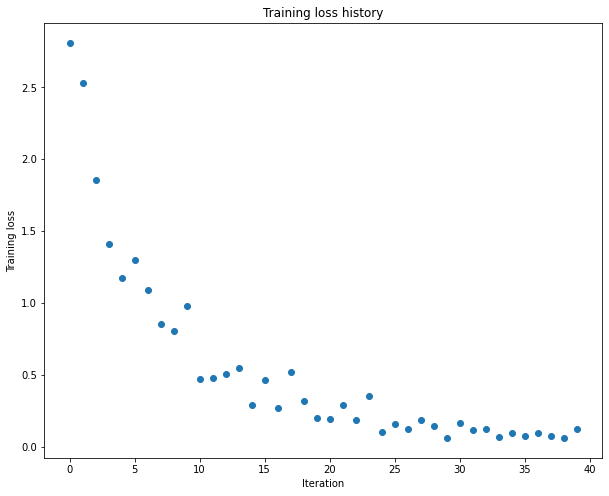

In [14]:
# TODO: Use a three-layer Net to overfit 50 training examples.

num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

############################################################################
# TODO: Tune these parameters to get 100% train accuracy within 20 epochs. #
############################################################################
weight_scale = 2e-2
learning_rate = 3e-3
############################################################################
#                             END OF YOUR CODE                             #
############################################################################

model = FullyConnectedNet([100, 100],
              weight_scale=weight_scale, dtype=np.float64)
solver = Solver(model, small_data,
                print_every=10, num_epochs=20, batch_size=25,
                update_rule='sgd',
                optim_config={
                  'learning_rate': learning_rate,
                }
         )
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

solver.record_histories_as_npz('submission_logs/overfit_3layer_fc.npz')

Now try to use a five-layer network with 100 units on each layer to overfit 50 training examples. Again you will have to adjust the learning rate and weight initialization, but you should be able to achieve 100% training accuracy within 20 epochs.

(Iteration 1 / 40) loss: 4.966306
(Epoch 0 / 20) train acc: 0.220000; val_acc: 0.087000
(Epoch 1 / 20) train acc: 0.360000; val_acc: 0.089000
(Epoch 2 / 20) train acc: 0.400000; val_acc: 0.111000
(Epoch 3 / 20) train acc: 0.560000; val_acc: 0.120000
(Epoch 4 / 20) train acc: 0.700000; val_acc: 0.130000
(Epoch 5 / 20) train acc: 0.680000; val_acc: 0.127000
(Iteration 11 / 40) loss: 0.769221
(Epoch 6 / 20) train acc: 0.840000; val_acc: 0.131000
(Epoch 7 / 20) train acc: 0.900000; val_acc: 0.127000
(Epoch 8 / 20) train acc: 0.920000; val_acc: 0.124000
(Epoch 9 / 20) train acc: 0.920000; val_acc: 0.127000
(Epoch 10 / 20) train acc: 0.940000; val_acc: 0.122000
(Iteration 21 / 40) loss: 0.386990
(Epoch 11 / 20) train acc: 0.960000; val_acc: 0.123000
(Epoch 12 / 20) train acc: 0.980000; val_acc: 0.129000
(Epoch 13 / 20) train acc: 0.960000; val_acc: 0.141000
(Epoch 14 / 20) train acc: 1.000000; val_acc: 0.131000
(Epoch 15 / 20) train acc: 1.000000; val_acc: 0.131000
(Iteration 31 / 40) loss: 

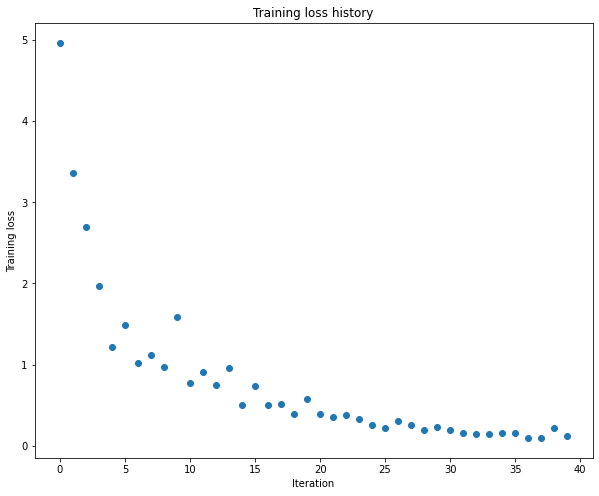

In [15]:
## TODO: Use a five-layer Net to overfit 50 training examples.

num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

############################################################################
# TODO: Tune these parameters to get 100% train accuracy within 20 epochs. #
############################################################################
weight_scale = 5e-2
learning_rate = 3e-3
############################################################################
#                             END OF YOUR CODE                             #
############################################################################

model = FullyConnectedNet([100, 100, 100, 100],
                weight_scale=weight_scale, dtype=np.float64)
solver = Solver(model, small_data,
                print_every=10, num_epochs=20, batch_size=25,
                update_rule='sgd',
                optim_config={
                  'learning_rate': learning_rate,
                }
         )
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

solver.record_histories_as_npz('submission_logs/overfit_5layer_fc.npz')

# Inline question: 
Did you notice anything about the comparative difficulty of training the three-layer net vs training the five layer net?

# Answer:
It is more difficult to tune the parameters to overfit with the five layer net, which requires higher variance weight initializations.

# Part 5) SGD+Momentum
So far we have used vanilla stochastic gradient descent (SGD) as our update rule. More sophisticated update rules can make it easier to train deep networks. For instance, stochastic gradient descent with momentum is a widely used update rule that tends to make deep networks converge faster than vanilla stochstic gradient descent.

Open the file `deeplearning/optim.py` and read the documentation at the top of the file to make sure you understand the API. Implement the SGD+momentum update rule in the function `sgd_momentum` and run the following to check your implementation. You should see errors less than 1e-8.

In [16]:
from deeplearning.optim import sgd_momentum

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(0.5, 1.5, num=N*D).reshape(N, D)
v = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-1, 'velocity': v}
next_w, _ = sgd_momentum(w, dw, config=config)

expected_next_w = np.asarray([
 [-0.504,      -0.45805263, -0.41210526, -0.36615789, -0.32021053],
 [-0.27426316, -0.22831579, -0.18236842, -0.13642105, -0.09047368],
 [-0.04452632,  0.00142105,  0.04736842,  0.09331579,  0.13926316],
 [ 0.18521053,  0.23115789,  0.27710526,  0.32305263,  0.369     ]])

expected_velocity = np.asarray([
 [1.04,       1.10684211, 1.17368421, 1.24052632, 1.30736842],
 [1.37421053, 1.44105263, 1.50789474, 1.57473684, 1.64157895],
 [1.70842105, 1.77526316, 1.84210526, 1.90894737, 1.97578947],
 [2.04263158, 2.10947368, 2.17631579, 2.24315789, 2.31      ]])

print ('next_w error: ', rel_error(next_w, expected_next_w))
print ('velocity error: ', rel_error(expected_velocity, config['velocity']))

next_w error:  9.259267785377383e-07
velocity error:  2.1398003469119033e-09


Once you have done so, run the following to train a six-layer network with both SGD and SGD+momentum. You should see the SGD+momentum update rule converge a bit faster.

running with  sgd
(Iteration 1 / 200) loss: 2.416305
(Epoch 0 / 5) train acc: 0.133000; val_acc: 0.120000
(Iteration 11 / 200) loss: 2.279317
(Iteration 21 / 200) loss: 2.137635
(Iteration 31 / 200) loss: 2.053534
(Epoch 1 / 5) train acc: 0.254000; val_acc: 0.242000
(Iteration 41 / 200) loss: 2.028445
(Iteration 51 / 200) loss: 1.965421
(Iteration 61 / 200) loss: 1.964507
(Iteration 71 / 200) loss: 1.793318
(Epoch 2 / 5) train acc: 0.309000; val_acc: 0.261000
(Iteration 81 / 200) loss: 1.923782
(Iteration 91 / 200) loss: 1.974642
(Iteration 101 / 200) loss: 1.785934
(Iteration 111 / 200) loss: 1.975821
(Epoch 3 / 5) train acc: 0.371000; val_acc: 0.302000
(Iteration 121 / 200) loss: 1.761942
(Iteration 131 / 200) loss: 1.794358
(Iteration 141 / 200) loss: 1.795502
(Iteration 151 / 200) loss: 1.654459
(Epoch 4 / 5) train acc: 0.396000; val_acc: 0.316000
(Iteration 161 / 200) loss: 1.619689
(Iteration 171 / 200) loss: 1.616250
(Iteration 181 / 200) loss: 1.685797
(Iteration 191 / 200) los

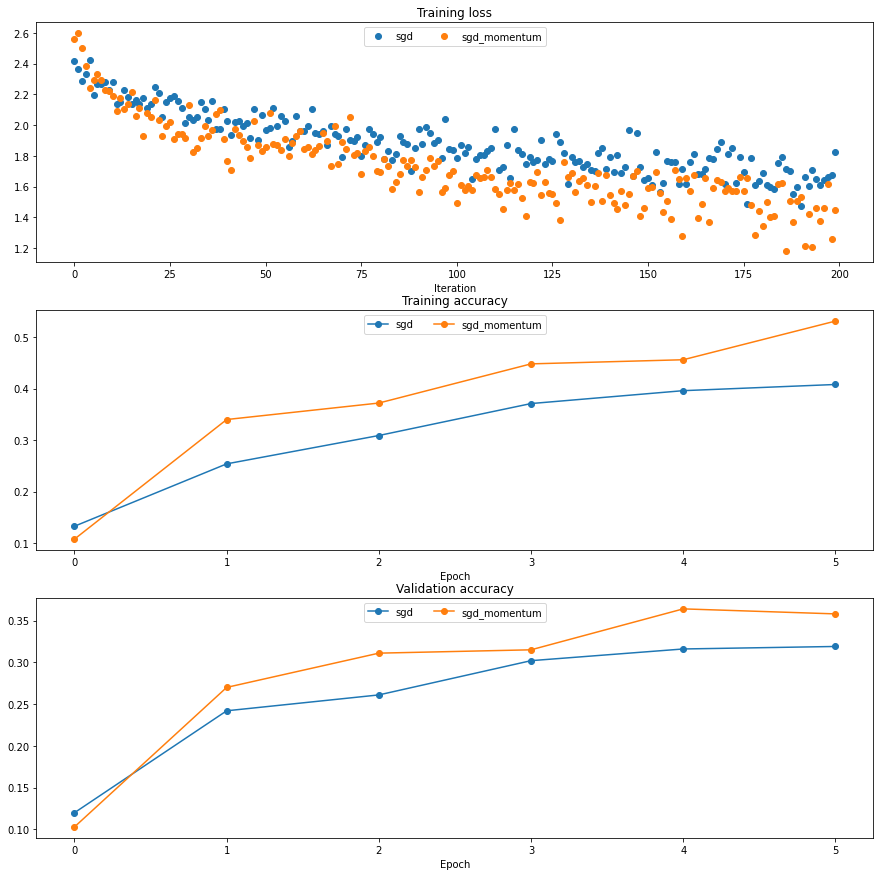

In [17]:
num_train = 4000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}

for update_rule in ['sgd', 'sgd_momentum']:
    print ('running with ', update_rule)
    model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2)

    solver = Solver(model, small_data,
                  num_epochs=5, batch_size=100,
                  update_rule=update_rule,
                  optim_config={
                    'learning_rate': 1e-2,
                  },
                  verbose=True)
    solvers[update_rule] = solver
    solver.train()
    solver.record_histories_as_npz("submission_logs/optimizer_experiment_{}".format(update_rule))
    print

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in solvers.items():
    plt.subplot(3, 1, 1)
    plt.plot(solver.loss_history, 'o', label=update_rule)

    plt.subplot(3, 1, 2)
    plt.plot(solver.train_acc_history, '-o', label=update_rule)

    plt.subplot(3, 1, 3)
    plt.plot(solver.val_acc_history, '-o', label=update_rule)

for i in [1, 2, 3]:
    plt.subplot(3, 1, i)
    plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

# Train a good model!
Train the best fully-connected model that you can on CIFAR-10, storing your best model in the `best_model` variable and the solver used in the `best_solver` variable. We require you to get at least 50% accuracy on the validation set using a fully-connected net.

In [19]:
best_model = None
best_solver = None
################################################################################
# TODO: Train the best FullyConnectedNet that you can on CIFAR-10. Store your  #
# best model in the best_model variable and the solver used to train it in the #
#best_solver variable.                                                         #
################################################################################
width = 500
n_layers = 2
model = FullyConnectedNet([width] * n_layers, 
                          weight_scale=2e-3, 
                          reg=3e-5)
lr = 5e-3
solver = Solver(model, 
                data,
                num_epochs=10, batch_size=100,
                update_rule='sgd_momentum',
                optim_config={
                  'learning_rate': lr
                },
                lr_decay=0.7,
                verbose=True)
solver.train()
best_model = model
best_solver = solver
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

(Iteration 1 / 4900) loss: 2.302055
(Epoch 0 / 10) train acc: 0.142000; val_acc: 0.171000
(Iteration 11 / 4900) loss: 2.274735
(Iteration 21 / 4900) loss: 2.095865
(Iteration 31 / 4900) loss: 1.801813
(Iteration 41 / 4900) loss: 2.098547
(Iteration 51 / 4900) loss: 1.983742
(Iteration 61 / 4900) loss: 1.855462
(Iteration 71 / 4900) loss: 1.824836
(Iteration 81 / 4900) loss: 1.829559
(Iteration 91 / 4900) loss: 1.881745
(Iteration 101 / 4900) loss: 1.887944
(Iteration 111 / 4900) loss: 1.766651
(Iteration 121 / 4900) loss: 2.096866
(Iteration 131 / 4900) loss: 1.802752
(Iteration 141 / 4900) loss: 1.765332
(Iteration 151 / 4900) loss: 1.854121
(Iteration 161 / 4900) loss: 1.994044
(Iteration 171 / 4900) loss: 2.087694
(Iteration 181 / 4900) loss: 1.769289
(Iteration 191 / 4900) loss: 1.805520
(Iteration 201 / 4900) loss: 1.697876
(Iteration 211 / 4900) loss: 1.652839
(Iteration 221 / 4900) loss: 2.026189
(Iteration 231 / 4900) loss: 2.025387
(Iteration 241 / 4900) loss: 1.591147
(Iterat

# Test your model
Run your best model on the validation and test sets and record the training logs of the best solver. You should achieve above 50% accuracy on the validation set.

In [20]:
y_test_pred = np.argmax(best_model.loss(data['X_test']), axis=1)
y_val_pred = np.argmax(best_model.loss(data['X_val']), axis=1)
val_acc = (y_val_pred == data['y_val']).mean()
test_acc = (y_test_pred == data['y_test']).mean()
print ('Validation set accuracy: ', val_acc)
print ('Test set accuracy: ', test_acc)
best_solver.record_histories_as_npz('submission_logs/best_fc_model.npz')

Validation set accuracy:  0.543
Test set accuracy:  0.542
